Performance énergétique des bâtiments

Aperçu rapide des données :

L'objectif est d'effectuer une analyse de régression pour prédire l'efficacité énergétique de différents types de bâtiments à partir de données étiquetées.  Pour les données d'entrée, 12 formes de bâtiments différentes ont été générées à l'aide de l'application Ecotect.  Ensuite, à l'aide de l'application NODEM, des simulations ont été effectuées pour prédire la charge de chauffage et de refroidissement pour chaque forme de bâtiment, tout en faisant varier trois autres paramètres : l'orientation, la surface vitrée et la distribution de la surface vitrée (ces deux dernières variables décrivent la transparence de l'enceinte, assurée par les fenêtres).  Les données brutes fournies sont les données d'entrée de ces simulations, ainsi que leurs résultats.  Cependant, au lieu de spécifier la forme exacte du bâtiment, cinq caractéristiques associées à la forme du bâtiment sont données.  Il s'agit de la compacité relative, de la surface, de la surface des murs, de la surface du toit et de la hauteur totale.  L'objectif de ce projet est de former un modèle d'apprentissage automatique capable de prédire la charge de chauffage et de refroidissement d'un type de bâtiment uniquement sur la base des huit caractéristiques d'entrée (sans s'appuyer sur des simulations coûteuses).


## Obtenir les données

Nous commencerons par charger les données dans un dataframe pandas.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(precision=4, suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline

buildings = pd.read_csv("ENBtable.csv").dropna()

RC, SA, WA, RA = "Relative Compactness", "Surface Area", "Wall Area", "Roof Area"
OH, O, GA, GAD = "Overall Height", "Orientation", "Glazing Area", "Glazing Area Distribution"
HL, CL = "Heating Load", "Cooling Load"

features, labels = list(buildings)[:8], list(buildings)[8:]
num_feats, cat_feats = features[:5]+[GA], [O, GAD]

categories = ['none', 'uniform', 'north', 'east', 'south', 'west']
converter = lambda k: categories[int(k)]
buildings[cat_feats] = buildings[cat_feats].applymap(converter)
buildings[O] = buildings[O].astype('category')
buildings[GAD] = buildings[GAD].astype('category')

buildings.head()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
0,0.980,514.500,294.000,110.250,7.000,north,0.000,none,15.550,21.330
1,0.980,514.500,294.000,110.250,7.000,east,0.000,none,15.550,21.330
2,0.980,514.500,294.000,110.250,7.000,south,0.000,none,15.550,21.330
3,0.980,514.500,294.000,110.250,7.000,west,0.000,none,15.550,21.330
4,0.900,563.500,318.500,122.500,7.000,north,0.000,none,20.840,28.280


Rappelez-vous que les deux dernières colonnes constituent les étiquettes (ce sont les variables "cibles") tandis que les huit premières colonnes sont nos caractéristiques de construction.  Examinons de plus près notre ensemble de données.

## Analyser les données

In [2]:
buildings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Relative Compactness       768 non-null    float64 
 1   Surface Area               768 non-null    float64 
 2   Wall Area                  768 non-null    float64 
 3   Roof Area                  768 non-null    float64 
 4   Overall Height             768 non-null    float64 
 5   Orientation                768 non-null    category
 6   Glazing Area               768 non-null    float64 
 7   Glazing Area Distribution  768 non-null    category
 8   Heating Load               768 non-null    float64 
 9   Cooling Load               768 non-null    float64 
dtypes: category(2), float64(8)
memory usage: 55.9 KB


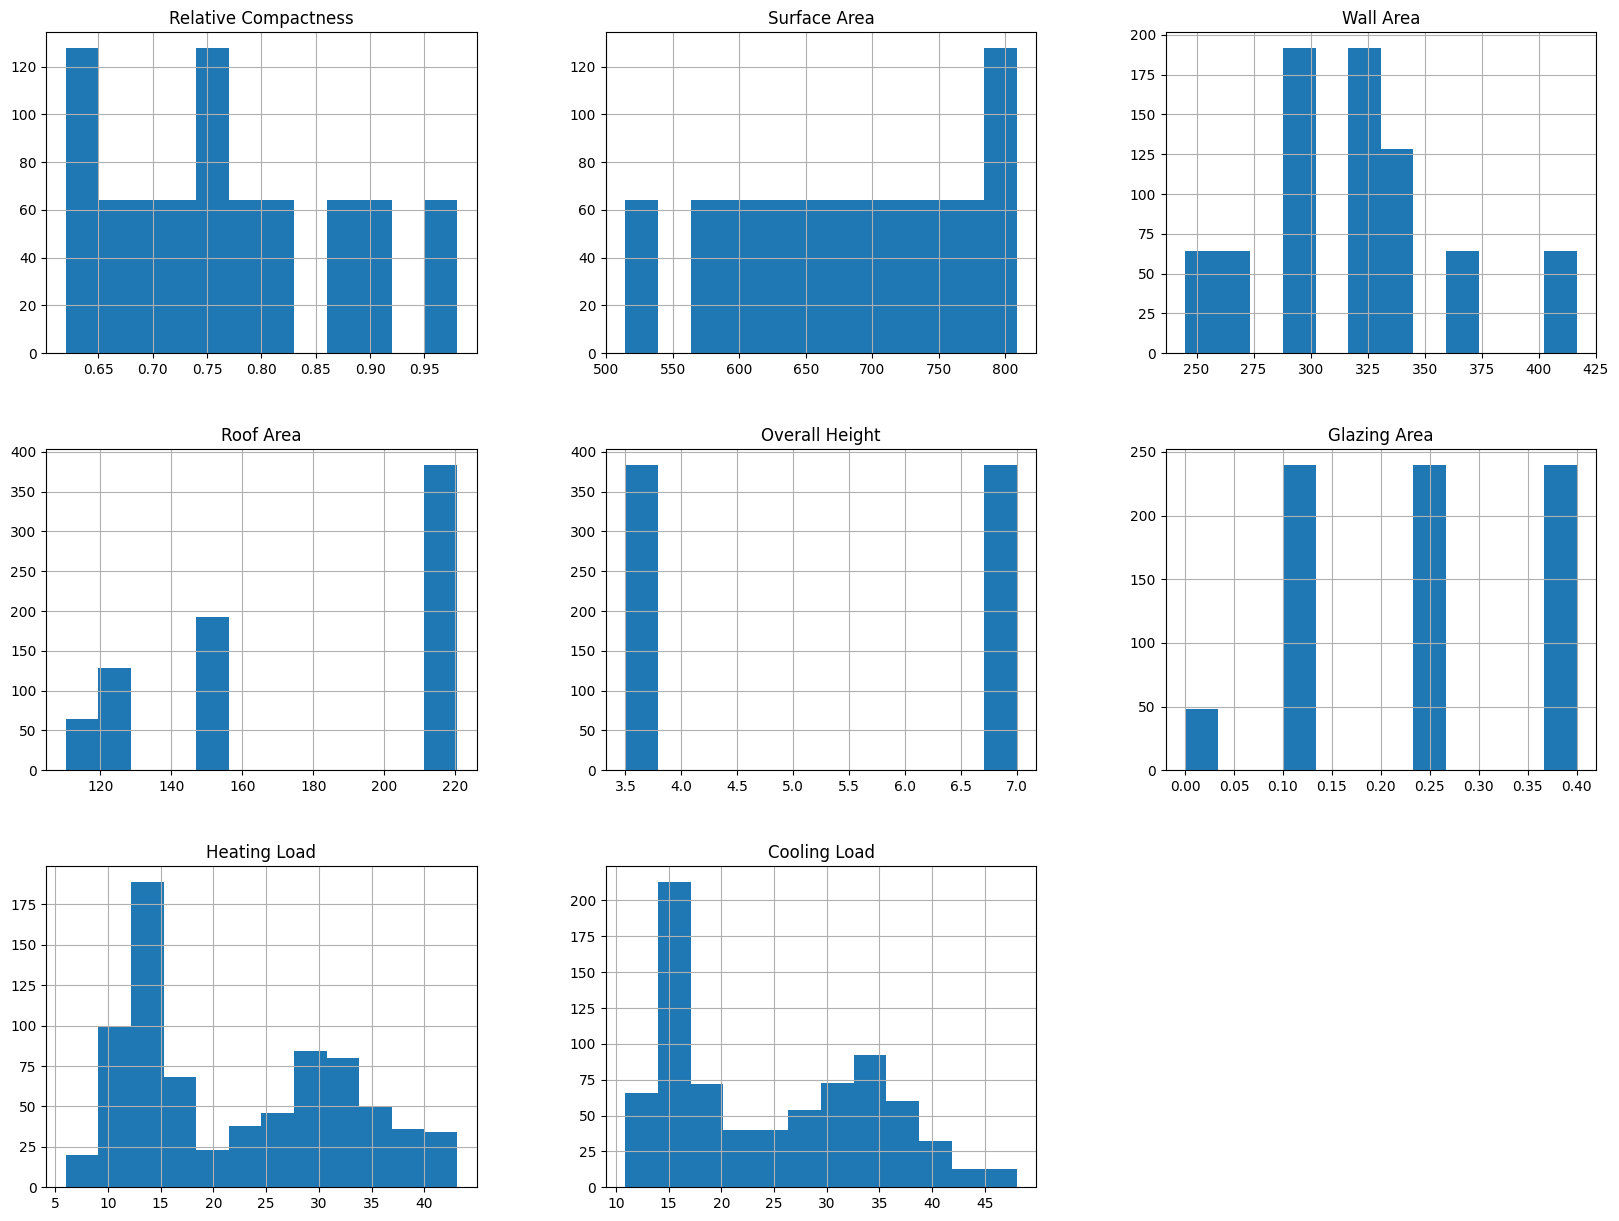

In [3]:
buildings.hist(bins=12, figsize=(20,15))
plt.show()

In [4]:
buildings.groupby([RC, SA, WA, RA, OH]).size()

Relative Compactness  Surface Area  Wall Area  Roof Area  Overall Height
0.620                 808.500       367.500    220.500    3.500             64
0.640                 784.000       343.000    220.500    3.500             64
0.660                 759.500       318.500    220.500    3.500             64
0.690                 735.000       294.000    220.500    3.500             64
0.710                 710.500       269.500    220.500    3.500             64
0.740                 686.000       245.000    220.500    3.500             64
0.760                 661.500       416.500    122.500    7.000             64
0.790                 637.000       343.000    147.000    7.000             64
0.820                 612.500       318.500    147.000    7.000             64
0.860                 588.000       294.000    147.000    7.000             64
0.900                 563.500       318.500    122.500    7.000             64
0.980                 514.500       294.000    110.250    

Ici, nous avons regroupé l'ensemble de données en fonction des cinq caractéristiques correspondant à la forme des bâtiments ; remarquez qu'il y a 12 lignes.  Chaque ligne donne les valeurs des caractéristiques correspondant à une forme de bâtiment donnée.  Par exemple, la moitié des bâtiments ont une hauteur de 3,5 m et l'autre moitié une hauteur de 7 m. Pour chaque forme de bâtiment, il existe 64 possibilités pour les formes restantes.  Pour chaque forme de bâtiment, il existe 64 possibilités pour les trois autres caractéristiques.  Notre ensemble de données comporte donc 12x64=768 lignes.

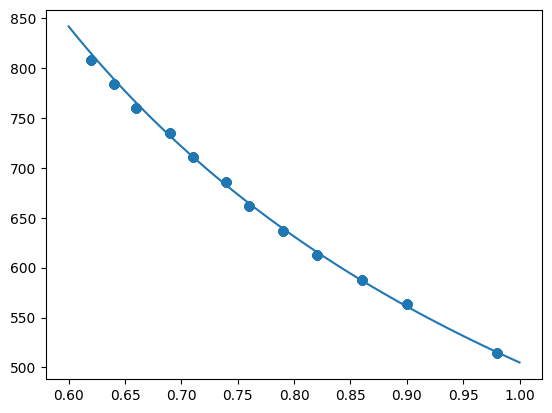

In [5]:
plt.scatter(buildings[RC], buildings[SA])
x = np.linspace(0.6, 1.0)
plt.plot(x, 505/x)
plt.show()

La compacité relative d'un bâtiment est une quantité sans unité égale à 6V^(2/3)/SA, où V est le volume de l'unité et SA la surface.  Le volume de chaque bâtiment étant identique, la compacité relative et la surface sont inversement proportionnelles, comme le montre le graphique ci-dessus.  Nous verrons que la compacité relative est la caractéristique la plus importante pour prédire la charge de chauffage et de refroidissement.

In [6]:
buildings.groupby([GA, GAD]).size()

Glazing Area  Glazing Area Distribution
0.000         east                          0
              none                         48
              north                         0
              south                         0
              uniform                       0
              west                          0
0.100         east                         48
              none                          0
              north                        48
              south                        48
              uniform                      48
              west                         48
0.250         east                         48
              none                          0
              north                        48
              south                        48
              uniform                      48
              west                         48
0.400         east                         48
              none                          0
              north                     

La surface vitrée (glazing area) est exprimée en fraction de la surface au sol et mesure le degré de transparence de l'enceinte.  La distribution de la surface vitrée indique comment les fenêtres ont tendance à être orientées dans le bâtiment.  Ce tableau montre les 16 combinaisons possibles de surface de vitrage et de distribution de surface de vitrage apparaissant dans cet ensemble de données.

In [7]:
buildings[[HL, CL]].std()

Heating Load   10.090
Cooling Load    9.513
dtype: float64

Ce tableau montre la variance globale de nos variables cibles.

In [8]:
(buildings[[O, GA, GAD, HL, CL]].groupby([O, GA, GAD]).std()).mean()

Heating Load   10.058
Cooling Load    9.607
dtype: float64

Ce tableau montre la variance moyenne de nos variables cibles lorsque l'orientation, la surface vitrée et la distribution de la surface vitrée sont connues.  Comme vous pouvez le constater, la variance est toujours la même, ce qui indique que ces variables en elles-mêmes nous donnent peu d'informations sur les variables cibles.

In [9]:
(buildings[[RC, HL, CL]].groupby(RC).std()).mean()

Heating Load   2.940
Cooling Load   2.472
dtype: float64

D'autre part, la compacité relative nous en apprend beaucoup sur la charge de chauffage et de refroidissement.  Comme vous pouvez le constater, lorsque la compacité relative est connue, la variance diminue considérablement.

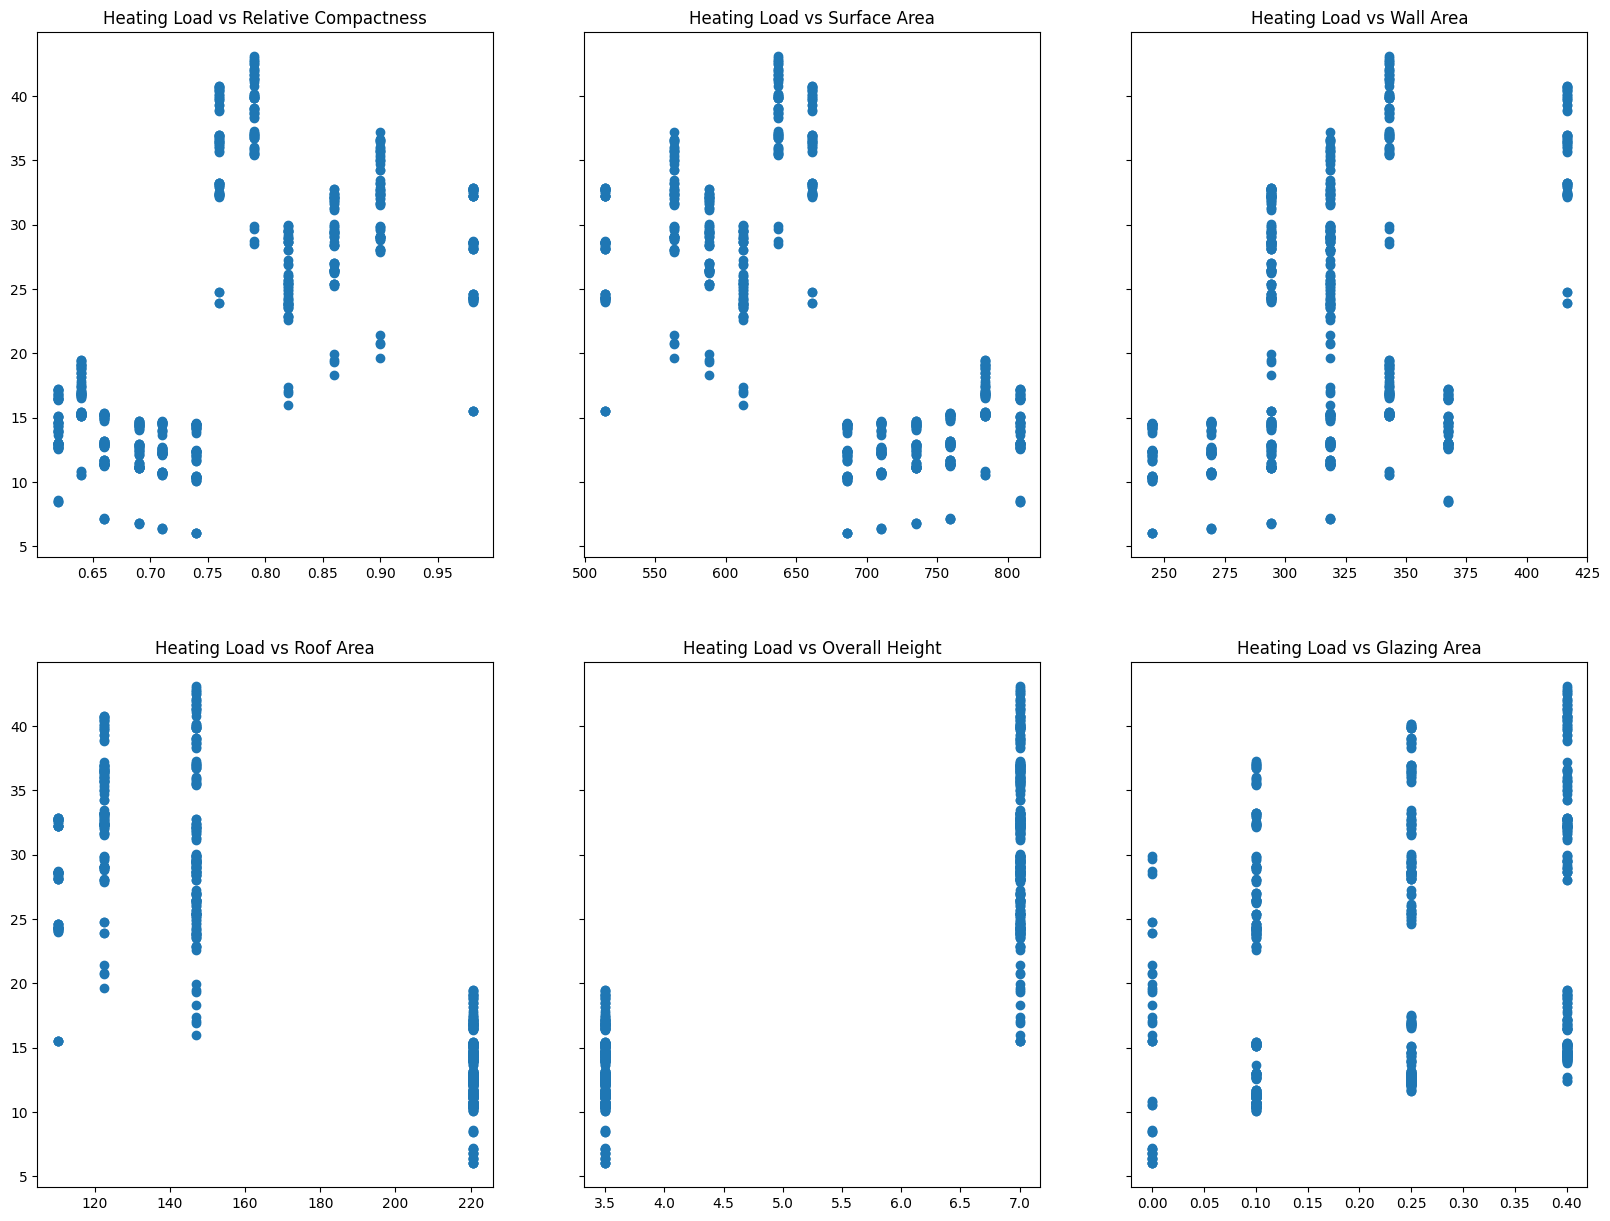

In [10]:
f, axarr = plt.subplots(2, 3, sharey=True, figsize=(20,15))
for i in range(6):
    axarr[i//3, i%3].scatter(buildings[num_feats[i]], buildings[HL])
    axarr[i//3, i%3].set_title("Heating Load vs " + num_feats[i])
plt.show()

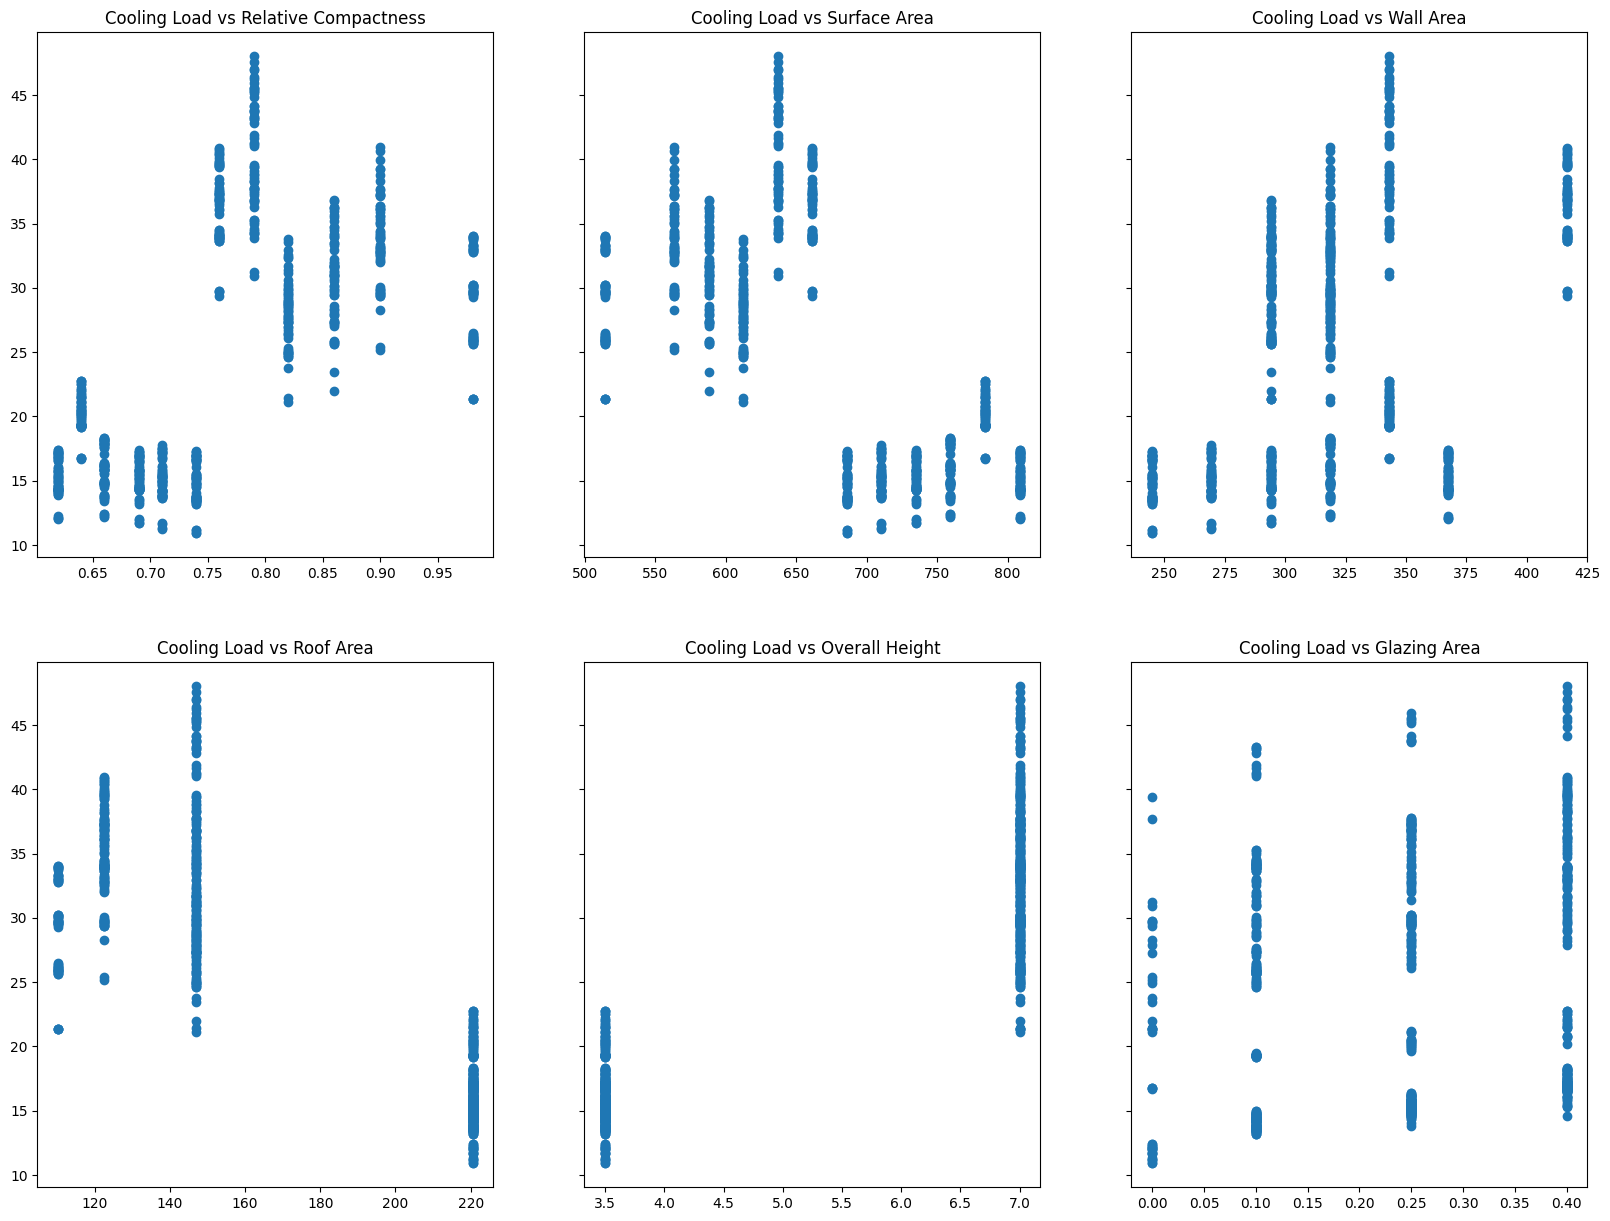

In [11]:
f, axarr = plt.subplots(2, 3, sharey=True, figsize=(20,15))
for i in range(6):
    axarr[i//3, i%3].scatter(buildings[num_feats[i]], buildings[CL])
    axarr[i//3, i%3].set_title("Cooling Load vs " + num_feats[i])
plt.show()

In [12]:
buildings.describe()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Glazing Area,Heating Load,Cooling Load
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,0.764,671.708,318.500,176.604,5.250,0.234,22.307,24.588
std,0.106,88.086,43.626,45.166,1.751,0.133,10.090,9.513
min,0.620,514.500,245.000,110.250,3.500,0.000,6.010,10.900
25%,0.682,606.375,294.000,140.875,3.500,0.100,12.992,15.620
50%,0.750,673.750,318.500,183.750,5.250,0.250,18.950,22.080
75%,0.830,741.125,343.000,220.500,7.000,0.400,31.668,33.133
max,0.980,808.500,416.500,220.500,7.000,0.400,43.100,48.030


Il s'agit simplement d'une description générale des variables numériques.  Maintenant que nous avons examiné les données, il est temps de les traiter.

## Traiter les données

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(buildings, buildings[RC]):
    strat_train_set = buildings.loc[train_index]
    strat_train_set.index = range(614)
    strat_test_set = buildings.loc[test_index]
strat_train_set.head()
#for loop only has one loop because n_splits=1
#len(train_index) = 614
#len(test_index) = 154

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
0,0.690,735.000,294.000,220.500,3.500,north,0.250,east,12.340,14.920
1,0.900,563.500,318.500,122.500,7.000,west,0.100,uniform,28.090,34.330
2,0.790,637.000,343.000,147.000,7.000,south,0.100,north,36.970,33.870
3,0.740,686.000,245.000,220.500,3.500,north,0.400,west,14.410,16.690
4,0.690,735.000,294.000,220.500,3.500,east,0.100,west,11.140,14.280


Ici, nous avons divisé les données de manière aléatoire en un ensemble de formation et un ensemble de test.  Nous avons procédé à une division stratifiée pour nous assurer que la distribution de la compacité relative dans les ensembles de formation et de test correspond à la distribution originale (la compacité relative étant un indicateur important, il est important qu'aucune de ses valeurs possibles ne soit sous/surreprésentée).

Nous ne devrions pas examiner l'ensemble de test avant d'avoir formé quelques bons modèles sur l'ensemble de formation.

In [14]:
buildings_feats, buildings_labels = strat_train_set[features], strat_train_set[labels]
buildings_num, buildings_cat = buildings_feats[num_feats], buildings_feats[cat_feats]
buildings_feats.head()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution
0,0.690,735.000,294.000,220.500,3.500,north,0.250,east
1,0.900,563.500,318.500,122.500,7.000,west,0.100,uniform
2,0.790,637.000,343.000,147.000,7.000,south,0.100,north
3,0.740,686.000,245.000,220.500,3.500,north,0.400,west
4,0.690,735.000,294.000,220.500,3.500,east,0.100,west


Ce tableau contient les données relatives aux caractéristiques de notre ensemble d'apprentissage.

In [15]:
buildings_cat.head(11)

,Orientation,Glazing Area Distribution
0,north,east
1,west,uniform
2,south,north
3,north,west
4,east,west
5,west,south
6,north,east
7,east,uniform
8,east,north
9,west,north


Un tableau composé des caractéristiques catégorielles de nos données d'apprentissage.  Nous allons devoir convertir ce tableau en une série de zéros et de uns à l'aide de la fonction OneHotEncoder de Scikit-Learn.  Tout d'abord, nous devons convertir les catégories en nombres entiers.

In [16]:
reverter = lambda x: categories.index(x)
buildings_cat_encoded = (np.vectorize(reverter))(buildings_cat.values)
buildings_cat_encoded[:11]

array([[2, 3],
       [5, 1],
       [4, 2],
       [2, 5],
       [3, 5],
       [5, 4],
       [2, 3],
       [3, 1],
       [3, 2],
       [5, 2],
       [2, 0]])

In [18]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder()  # OneHotEncoder(n_values=6)
buildings_cat_1hot = one_hot_encoder.fit_transform(buildings_cat_encoded)
buildings_cat_1hot

<614x10 sparse matrix of type '<class 'numpy.float64'>'
	with 1228 stored elements in Compressed Sparse Row format>

In [19]:
(buildings_cat_1hot.toarray())[:11]

array([[1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

Notre tableau de caractéristiques catégorielles a été transformé en un tableau de zéros et de uns.  Nous allons maintenant créer un pipeline qui effectuera toutes les étapes nécessaires au traitement des données en une seule fois.  Cela nous sera utile plus tard lorsque nous devrons appliquer les mêmes transformations aux données des caractéristiques de notre ensemble de test.

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Cette classe peut prendre un cadre de données et sélectionner les valeurs dans un certain nombre de colonnes spécifiées (les noms des attributs).  Nous l'utiliserons pour diviser nos données de caractéristiques en données numériques et en données catégorielles.

In [21]:
class CatEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = (np.vectorize(reverter))(X)
        return (one_hot_encoder.fit_transform(X)).toarray()

L'encodeur catégorique.  Il prend les données catégorielles et les transforme en un tableau de zéros et de uns comme nous l'avons fait ci-dessus.

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_feats)),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_feats)),
        ('cat_encoder', CatEncoder()),
    ])

Le pipeline numérique sélectionne les caractéristiques numériques et met les valeurs à l'échelle.  Le pipeline catégorique sélectionne les données catégorielles et convertit les catégories en zéros et en uns.

In [23]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

Cela permet de réunir les deux pipelines susmentionnés.

In [24]:
buildings_prepared = full_pipeline.fit_transform(buildings_feats)
buildings_prepared.shape

(614, 16)

In [25]:
buildings_prepared[:10,:6]

array([[-0.7049,  0.7223, -0.5618,  0.9756, -1.0033,  0.1192],
       [ 1.2809, -1.2253,  0.0009, -1.1958,  0.9967, -1.0184],
       [ 0.2407, -0.3906,  0.5636, -0.6529,  0.9967, -1.0184],
       [-0.2321,  0.1658, -1.6873,  0.9756, -1.0033,  1.2568],
       [-0.7049,  0.7223, -0.5618,  0.9756, -1.0033, -1.0184],
       [-0.043 , -0.1124,  2.2518, -1.1958,  0.9967,  0.1192],
       [-0.043 , -0.1124,  2.2518, -1.1958,  0.9967,  0.1192],
       [ 0.9027, -0.9471, -0.5618, -0.6529,  0.9967,  0.1192],
       [-1.1777,  1.2788,  0.5636,  0.9756, -1.0033, -1.0184],
       [ 1.2809, -1.2253,  0.0009, -1.1958,  0.9967,  0.1192]])

Nos données numériques mises à l'échelle.

In [26]:
buildings_prepared[:10,6:]

array([[1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0., 0.]])

Nos données catégorielles transformées.

## Entrainements de modèle

Nous allons maintenant entraîner quelques modèles.  Je définirai ici une fonction add_regressor qui prendra en entrée un régresseur (ainsi que son nom) et entraînera le régresseur sur les données d'apprentissage à l'aide de la validation croisée.  Chaque régresseur est entraîné à prédire à la fois la charge de chauffage et la charge de refroidissement, de sorte que deux régresseurs sont créés dans chaque application de la fonction add_regressor.  Après avoir formé les régresseurs, add_regressor les stocke dans un dictionnaire en vue d'une utilisation ultérieure.  Il imprime également un score pour les deux régresseurs et stocke les scores dans un tableau de scores qui peut être consulté ultérieurement pour comparer différents classificateurs.

Enfin, il est possible de transmettre à add_regressor une série de valeurs pour les hyperparamètres du modèle (par exemple, le taux d'apprentissage, etc.). add_regressor utilisera une grille de recherche pour trouver les paramètres qui fonctionnent le mieux.

In [27]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

regressors = {HL: {}, CL: {}}
columns = ["Training RMSE", "Cross Validation RMSE", "Cross Validation SD"]
tables = {HL: pd.DataFrame(columns=columns), CL: pd.DataFrame(columns=columns)}

def add_regressor(regressor, name, param_grid=None, data=buildings_prepared,
              targets=buildings_labels):
    for label in targets:
        print(label)
        target = targets[label]
        if param_grid is None:
            best_regressor = regressor
        else:
            grid_search = GridSearchCV(regressor, param_grid, cv=5,
                                       scoring='neg_mean_squared_error')
            grid_search.fit(data, target);
            best_regressor = grid_search.best_estimator_
        best_regressor.fit(data, target)
        predictions = best_regressor.predict(data)
        rmse = np.sqrt(mean_squared_error(target, predictions))
        scores = cross_val_score(best_regressor, data, target,
                         scoring="neg_mean_squared_error", cv=10)
        scores = np.sqrt(-scores)
        regressors[target.name][name] = best_regressor
        values = dict(zip(columns, [rmse, scores.mean(), scores.std()]))
        row = pd.DataFrame(values, index=[name], columns=columns)
        print(row)
        table = tables[target.name].append(row)
        tables[target.name] = table[~table.index.duplicated(keep='last')]

In [28]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
add_regressor(lin_reg, "Linear Regression")

Heating Load
                   Training RMSE  Cross Validation RMSE  Cross Validation SD
Linear Regression          2.760                  2.846                0.205
Cooling Load
                   Training RMSE  Cross Validation RMSE  Cross Validation SD
Linear Regression          3.188                  3.274                0.270


/var/folders/7q/5sn_ssd501gcz8xq_xyjv7gm0000gn/T/ipykernel_5757/1444181528.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = tables[target.name].append(row)
/var/folders/7q/5sn_ssd501gcz8xq_xyjv7gm0000gn/T/ipykernel_5757/1444181528.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = tables[target.name].append(row)


The scores for using a simple linear regression model.  RMSE stands for "root mean squared error".

In [29]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
add_regressor(tree_reg, "Decision Tree")

Heating Load
               Training RMSE  Cross Validation RMSE  Cross Validation SD
Decision Tree          0.000                  0.624                0.077
Cooling Load
               Training RMSE  Cross Validation RMSE  Cross Validation SD
Decision Tree          0.000                  2.502                0.272


/var/folders/7q/5sn_ssd501gcz8xq_xyjv7gm0000gn/T/ipykernel_5757/1444181528.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = tables[target.name].append(row)
/var/folders/7q/5sn_ssd501gcz8xq_xyjv7gm0000gn/T/ipykernel_5757/1444181528.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = tables[target.name].append(row)


Don't let the zero training error fool you.  That means this model might be overfitting the data.  Still, the cross validation errors are lower than the linear regression cv errors.

In [30]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]
add_regressor(forest_reg, "Forest Regression", param_grid)

Heating Load
                   Training RMSE  Cross Validation RMSE  Cross Validation SD
Forest Regression          0.212                  0.587                0.056
Cooling Load


/var/folders/7q/5sn_ssd501gcz8xq_xyjv7gm0000gn/T/ipykernel_5757/1444181528.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = tables[target.name].append(row)


                   Training RMSE  Cross Validation RMSE  Cross Validation SD
Forest Regression          0.651                  1.659                0.222


/var/folders/7q/5sn_ssd501gcz8xq_xyjv7gm0000gn/T/ipykernel_5757/1444181528.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = tables[target.name].append(row)


Those are some small errors!  Looks like this is a pretty good regressor.  Let's try some more models.

In [32]:
from sklearn.linear_model import Lasso

lasso = Lasso()
param_grid = {"alpha": [0.03, 0.1, 0.3, 1]}
add_regressor(lasso, "Lasso", param_grid)

Heating Load
       Training RMSE  Cross Validation RMSE  Cross Validation SD
Lasso          2.805                  2.871                0.217
Cooling Load
       Training RMSE  Cross Validation RMSE  Cross Validation SD
Lasso          3.229                  3.296                0.294


/var/folders/7q/5sn_ssd501gcz8xq_xyjv7gm0000gn/T/ipykernel_5757/1444181528.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = tables[target.name].append(row)
/var/folders/7q/5sn_ssd501gcz8xq_xyjv7gm0000gn/T/ipykernel_5757/1444181528.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = tables[target.name].append(row)


In [33]:
from sklearn.linear_model import ElasticNet

enet = ElasticNet()
param_grid = {"alpha": [0.03, 0.1, 0.3, 1],
              "l1_ratio": list(np.linspace(0.1,0.9,9))}
add_regressor(enet, "Elastic Net", param_grid)

Heating Load
             Training RMSE  Cross Validation RMSE  Cross Validation SD
Elastic Net          2.808                  2.874                0.232
Cooling Load


/var/folders/7q/5sn_ssd501gcz8xq_xyjv7gm0000gn/T/ipykernel_5757/1444181528.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = tables[target.name].append(row)


             Training RMSE  Cross Validation RMSE  Cross Validation SD
Elastic Net          3.232                  3.298                0.308


/var/folders/7q/5sn_ssd501gcz8xq_xyjv7gm0000gn/T/ipykernel_5757/1444181528.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = tables[target.name].append(row)


In [34]:
from sklearn.svm import SVR

svr_lin = SVR(kernel='linear')
param_grid = {"C": [1e0, 1e1, 1e2], "gamma": np.logspace(-2,2,5)}
add_regressor(svr_lin, "Linear SVR", param_grid)

Heating Load
            Training RMSE  Cross Validation RMSE  Cross Validation SD
Linear SVR          2.829                  2.899                0.287
Cooling Load


/var/folders/7q/5sn_ssd501gcz8xq_xyjv7gm0000gn/T/ipykernel_5757/1444181528.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = tables[target.name].append(row)


            Training RMSE  Cross Validation RMSE  Cross Validation SD
Linear SVR          3.299                  3.408                0.367


/var/folders/7q/5sn_ssd501gcz8xq_xyjv7gm0000gn/T/ipykernel_5757/1444181528.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = tables[target.name].append(row)


In [35]:
svr_rbf = SVR(kernel='rbf')
param_grid = {"C": [1e0, 1e1, 1e2], "gamma": np.logspace(-2,2,5)}
add_regressor(svr_rbf, "RBF SVR", param_grid)

Heating Load
         Training RMSE  Cross Validation RMSE  Cross Validation SD
RBF SVR          1.147                  1.583                0.303
Cooling Load


/var/folders/7q/5sn_ssd501gcz8xq_xyjv7gm0000gn/T/ipykernel_5757/1444181528.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = tables[target.name].append(row)


         Training RMSE  Cross Validation RMSE  Cross Validation SD
RBF SVR          1.373                  2.229                0.260


/var/folders/7q/5sn_ssd501gcz8xq_xyjv7gm0000gn/T/ipykernel_5757/1444181528.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = tables[target.name].append(row)


Now let's look at our tables to compare the errors for our regressors.

In [36]:
tables[HL]

,Training RMSE,Cross Validation RMSE,Cross Validation SD
Linear Regression,2.760,2.846,0.205
Decision Tree,0.000,0.624,0.077
Forest Regression,0.212,0.587,0.056
Lasso,2.805,2.871,0.217
Elastic Net,2.808,2.874,0.232
Linear SVR,2.829,2.899,0.287
RBF SVR,1.147,1.583,0.303


In [37]:
tables[CL]

,Training RMSE,Cross Validation RMSE,Cross Validation SD
Linear Regression,3.188,3.274,0.270
Decision Tree,0.000,2.502,0.272
Forest Regression,0.651,1.659,0.222
Lasso,3.229,3.296,0.294
Elastic Net,3.232,3.298,0.308
Linear SVR,3.299,3.408,0.367
RBF SVR,1.373,2.229,0.260


Nous voulons ici comparer les erreurs de validation croisée.  Il semble que la régression forestière soit notre meilleur choix.  Une chose que nous pouvons voir dans ces tableaux est qu'il est plus difficile de prédire la charge de refroidissement que la charge de chauffage.

In [38]:
final_models = {label: regressors[label]["Forest Regression"] for label in labels}

## Test du modèle

Nous pouvons enfin tester notre régresseur sur les données de test.  Nous allons simplement appliquer notre pipeline ci-dessus aux données de test pour les préparer.  Ensuite, nous pouvons appliquer notre régresseur forestier entraîné aux caractéristiques de test.

In [39]:
test_features = strat_test_set[features]
test_labels = strat_test_set[labels]

test_prepared = full_pipeline.transform(test_features)
final_predictions = {label: final_models[label].predict(test_prepared) for label in labels}

final_mse = {label: mean_squared_error(test_labels[label], final_predictions[label])
            for label in labels}
final_rmse = {label: np.sqrt(final_mse[label]) for label in labels}
print("Heating Load RMSE:", final_rmse[HL])
print("Cooling Load RMSE:", final_rmse[CL])

Heating Load RMSE: 0.4705427939343249
Cooling Load RMSE: 1.4041308311739997


Pas mal !  Voici nos résultats finaux.  Il semble que notre régresseur forestier ait été capable de faire un assez bon travail de prédiction sur les données de test.

In [40]:
HL_results = pd.DataFrame({"Predictions": final_predictions[HL], "Actual": test_labels[HL]})
HL_results.index = range(154)
CL_results = pd.DataFrame({"Predictions": final_predictions[CL], "Actual": test_labels[CL]})
CL_results.index = range(154)

In [41]:
HL_results.head(10)

,Predictions,Actual
0,10.173,10.070
1,19.092,19.420
2,10.366,10.360
3,41.494,41.090
4,14.470,14.580
5,7.133,7.180
6,32.200,32.670
7,28.689,28.640
8,39.228,40.030
9,13.031,12.820


In [42]:
CL_results.head(10)

,Predictions,Actual
0,13.992,13.210
1,21.612,22.530
2,14.015,13.430
3,43.531,47.010
4,16.917,17.470
5,12.516,12.400
6,32.149,33.060
7,29.817,28.950
8,39.069,37.810
9,16.159,16.030


Enfin, ces tableaux montrent les valeurs de charge de chauffage et de refroidissement prévues par rapport aux valeurs réelles (simulées).